<a href="https://colab.research.google.com/github/AlexeySto/A-B_test_DZ_seminar_9/blob/main/A_B_test_DZ_seminar_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd

# Считывание данных
data = pd.read_csv('/content/cookie_cats_original_order.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,1711136,Gate at lvl 40,20,False,False
1,2964858,Gate at lvl 40,20,True,False
2,3433251,Gate at lvl 40,20,False,False
3,8452399,Gate at lvl 40,20,True,True
4,2854126,Gate at lvl 40,20,True,True


In [15]:
# Смотрим информацию о полученных данных
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [16]:
# Очистка данных
# Удаление дубликатов
data.drop_duplicates(inplace=True)

# Обработка пропущенных значений, если таковые есть
data.dropna(inplace=True)

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [17]:
# Подсчитывается количество игроков в каждой группе AB.
data.groupby('version')['version'].count()

version
Gate at lvl 30    44700
Gate at lvl 40    45489
Name: version, dtype: int64

В каждой группе примерно одинаковое количество игроков

In [18]:
# Процент пользователей, вернувшихся на следующий день после установки
data.groupby('version')['retention_1'].mean()

version
Gate at lvl 30    0.448188
Gate at lvl 40    0.442283
Name: retention_1, dtype: float64

Text(0, 0.5, 'Плотность')

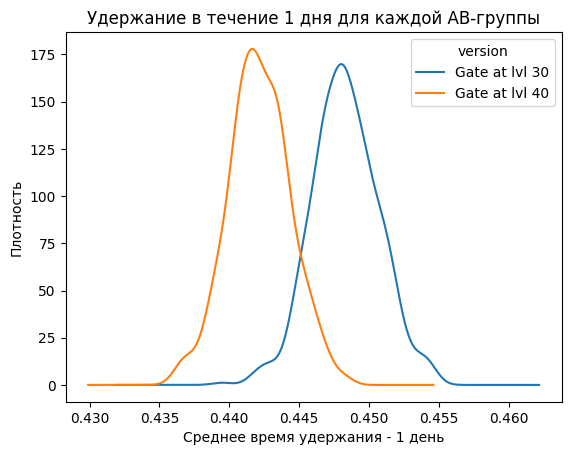

In [21]:
# Создание списка с загруженными средствами для каждой AB-группы
boot_1d = []
iterations = 500
for i in range(iterations):
    boot_mean = data.sample(frac=1, replace=True).groupby(
        'version')['retention_1'].mean()
    boot_1d.append(boot_mean)

# Преобразование списка во фрейм данных
boot_1d = pd.DataFrame(boot_1d)

# График оценки плотности ядра для распределений bootstrap
ax = boot_1d.plot.kde()
ax.set_title('Удержание в течение 1 дня для каждой AB-группы')
ax.set_xlabel('Среднее время удержания - 1 день')
ax.set_ylabel('Плотность')

На этот графике, мы можем увидеть, что, по-видимому, есть некоторые признаки разницы, хотя и небольшой. Увеличим разницу в сроках удержания в течение 1 дня

In [22]:
# удалим пробелы в названии столбцов
boot_1d = boot_1d.rename(columns= {'Gate at lvl 30': 'Gate_at_lvl_30'})
boot_1d = boot_1d.rename(columns= {'Gate at lvl 40': 'Gate_at_lvl_40'})

# проверка первых нескольких строк boot_1d
boot_1d.head()

version,Gate_at_lvl_30,Gate_at_lvl_40
retention_1,0.448743,0.441264
retention_1,0.445926,0.436964
retention_1,0.448356,0.444777
retention_1,0.450792,0.443430
retention_1,0.447442,0.438744


Text(0, 0.5, 'Плотность')

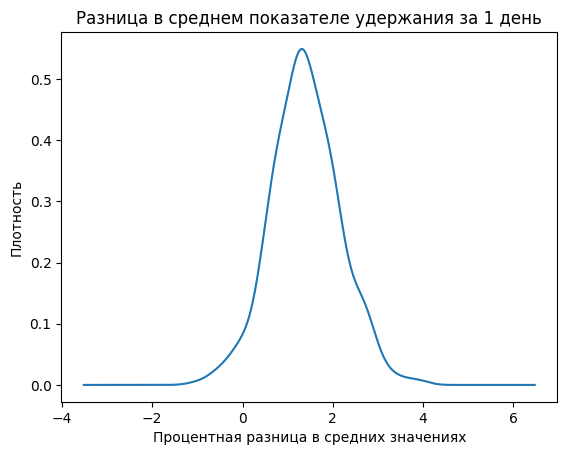

In [26]:
# Добавление столбца с разницей в процентах между двумя AB-группами
boot_1d['diff'] = ((boot_1d.Gate_at_lvl_30 - boot_1d.	Gate_at_lvl_40)
                   / boot_1d.	Gate_at_lvl_40 * 100)

# Построение графика разницы в процентах начальной загрузки
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel('Процентная разница в средних значениях')
ax.set_title('Разница в среднем показателе удержания за 1 день')
ax.set_ylabel('Плотность')

Из этого графика видно, что наиболее вероятная разница в процентах составляет около 1-2%, и что большая часть распределения превышает 0%, что говорит в пользу нулевой гипотезы.

In [25]:
# Вычисление вероятности того, что удержание на 1 день будет больше для контрольной группы
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d['diff'])

'{0:.1%}'.format(prob)

'96.2%'

Анализ показывает, что существует высокая вероятность того, что 1-дневное удержание лучше для контрольной группы. Однако, поскольку игроки играют в игру всего один день, вполне вероятно, что большинство игроков еще не достигли ни  30-го, ни 40-го уровня. Но после недельной игры большее количество игроков должно было достичь 40-го уровня, и поэтому имеет смысл также рассмотреть возможность 7-дневного удержания.

In [27]:
# Расчет 7-дневного удержания для обеих групп
data.groupby('version')['retention_7'].mean()

version
Gate at lvl 30    0.190201
Gate at lvl 40    0.182000
Name: retention_7, dtype: float64

'100.0%'

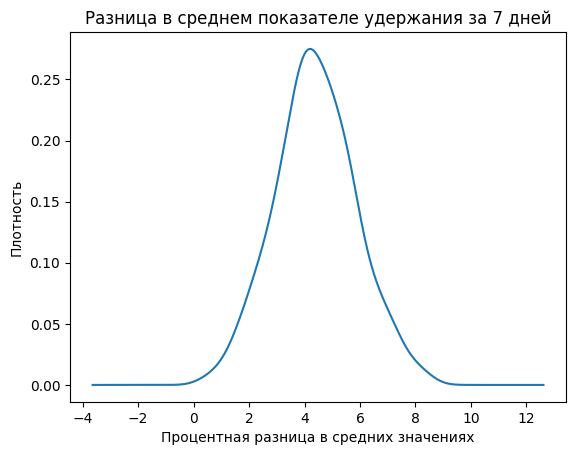

In [29]:
# Создание списка с загруженными средствами для каждой AB-группы
boot_7d = []
for i in range(500):
    boot_mean = data.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()
    boot_7d.append(boot_mean)

# Преобразование списка во фрейм данных
boot_7d = pd.DataFrame(boot_7d)

# Добавление столбца с разницей в процентах между двумя AB-группами
boot_7d['diff'] = ((boot_7d['Gate at lvl 30'] - boot_7d['Gate at lvl 40']) /
                   boot_7d['Gate at lvl 40'] * 100)

# Построение графика разницы в процентах начальной загрузки
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel('Процентная разница в средних значениях')
ax.set_title('Разница в среднем показателе удержания за 7 дней')
ax.set_ylabel('Плотность')

# Вычисление вероятности того, что 7-дневное удержание будет больше, для контрольной группы
prob = (boot_7d['diff'] > 0).mean()

'{0:.1%}'.format(prob)

Исходя из результатов А-Б теста, где удержание игроков оказалось выше для контрольной группы, можно дать следующие рекомендации менеджеру:

1. Провести более подробный анализ данных, чтобы понять причины различия в удержании между контрольной и тестовой группами. Возможно, есть другие факторы, которые также влияют на удержание игроков.

2. Продолжить мониторинг удержания игроков в обеих группах после прохождения времени для оценки долгосрочного влияния изменений.

3. Исследовать другие метрики успеха игры (например, конверсию в оплату, средний чек игрока), чтобы оценить полный эффект изменений на игровой процесс.

4. Изучить отзывы игроков о новых изменениях в игре, и использовать их обратную связь для улучшения пользовательского опыта.

В целом, рекомендуется провести более глубокий анализ данных, продолжить мониторинг результатов и использовать информацию для постоянного улучшения игрового процесса.